<a href="https://colab.research.google.com/github/ankitkatiyar91/bytefold/blob/master/knowledge_graph_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to data: https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/10/wiki_sentences_v2.csv

In [0]:
import io
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [5]:
from google.colab import files
uploaded = files.upload()

Saving wiki_sentences_v2.csv to wiki_sentences_v2.csv


In [8]:
# import wikipedia sentences
uploaded

{'wiki_sentences_v2.csv': b'sentence\n"confused and frustrated, connie decides to leave on her own."\n"later, a woman\xe2\x80\x99s scream is heard in the distance."\nchristian is then paralyzed by an elder.\nthe temple is set on fire.\n"outside, the cult wails with him."\nit\'s a parable of a woman\'s religious awakening\xe2\x80\x94\n"c. mackenzie, and craig vincent joined the cast."\n"later, craig di francia and action bronson were revealed to have joined the cast."\nsebastian maniscalco and paul ben-victor were later revealed as being part of the cast.\nwe just tried to make the film.\nwe went through all these tests and things  \nm global was also circling to bid for the film\'s international sales rights.\ncanadian musician robbie robertson supervised the soundtrack.\nit features both original and existing music tracks.\nit is the worst reviewed film in the franchise.\nbut she injures quicksilver and accidentally kills mystique before flying away.\nmilitary forces tasked with her a

In [0]:
candidate_sentences = pd.read_csv(io.BytesIO(uploaded['wiki_sentences_v2.csv']))

In [18]:
candidate_sentences.shape

(4318, 1)

In [21]:
candidate_sentences.info

<bound method DataFrame.info of                                                                                                                                                                                                      sentence
0                                                                                                                                                confused and frustrated, connie decides to leave on her own.
1                                                                                                                                                           later, a woman’s scream is heard in the distance.
2                                                                                                                                                                    christian is then paralyzed by an elder.
3                                                                                                                                               

In [22]:
candidate_sentences['sentence'].sample(5)

1941                                            nfb documentaries are also available on netflix canada.
1398                                            in the philippines, aquaman is the biggest warner bros.
2267                     a soundtrack typically contains instrumentation or alternatively a film score.
1585    the remaining majority portion is spread across northern, western, eastern and southern india .
3134                                                      he portrayed rudra pratap singh, a raw agent.
Name: sentence, dtype: object

In [23]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


In [0]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [25]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [26]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:28<00:00, 152.82it/s]


In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [28]:
get_entities("John completed the task")

['John', 'task']

In [29]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:28<00:00, 152.31it/s]


In [30]:
pd.Series(relations).value_counts()[:50]

is               368
was              283
released on       79
are               72
include           69
were              63
's                42
released          41
have              30
has               30
became            29
composed by       29
become            28
released in       28
considered        22
included          21
had               19
be                19
called            19
produced          19
been              18
stars             18
used              18
scheduled         17
made              16
directed by       15
wrote             14
set               14
hired             14
went              14
written by        13
introduced in     13
received          13
sold              12
wanted            12
cast as           11
won               11
includes          10
began in          10
began             10
features          10
gave              10
produced by       10
used in            9
gives              9
shot in            9
directed           9
reported     

In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [0]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

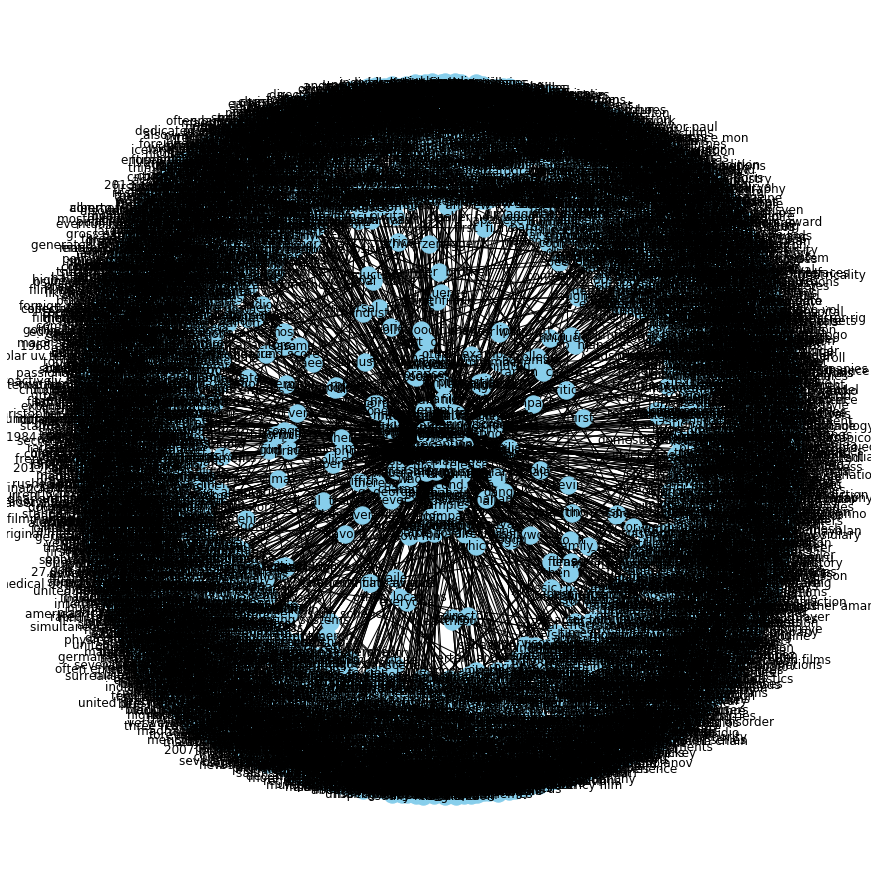

In [36]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

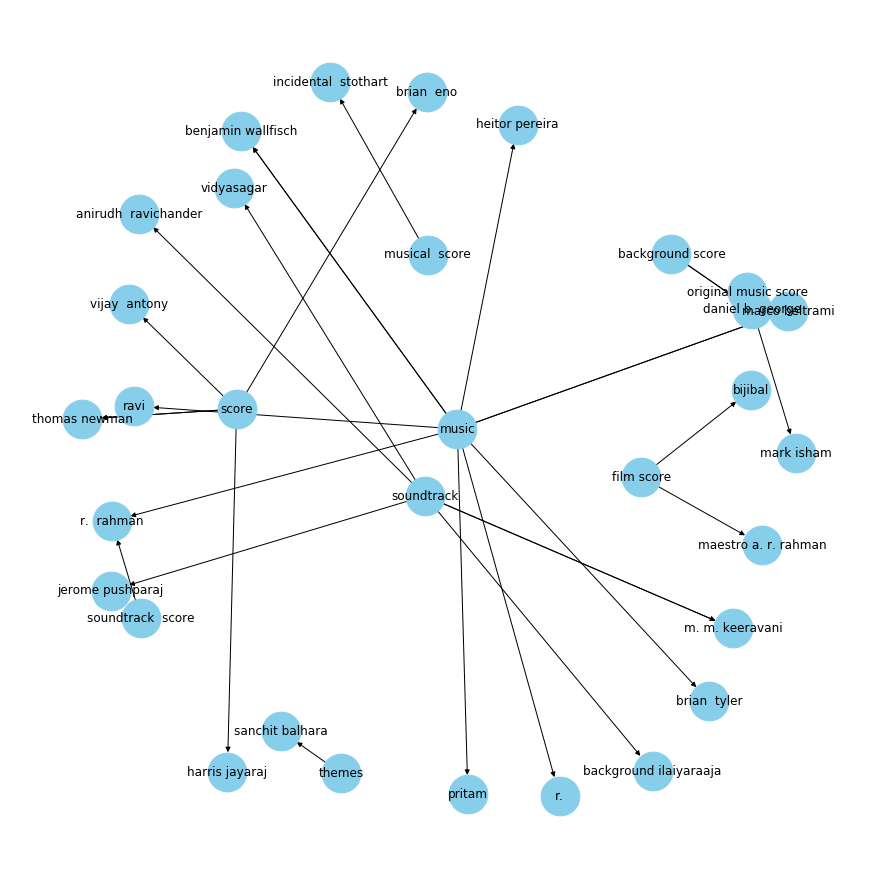

In [37]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

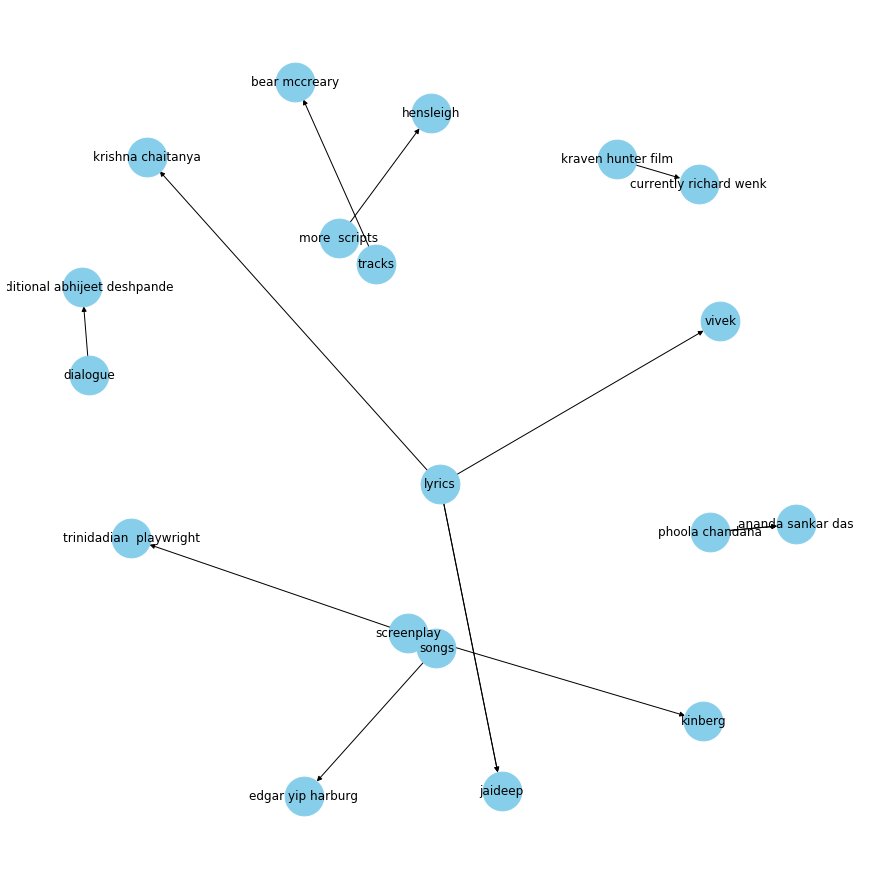

In [38]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

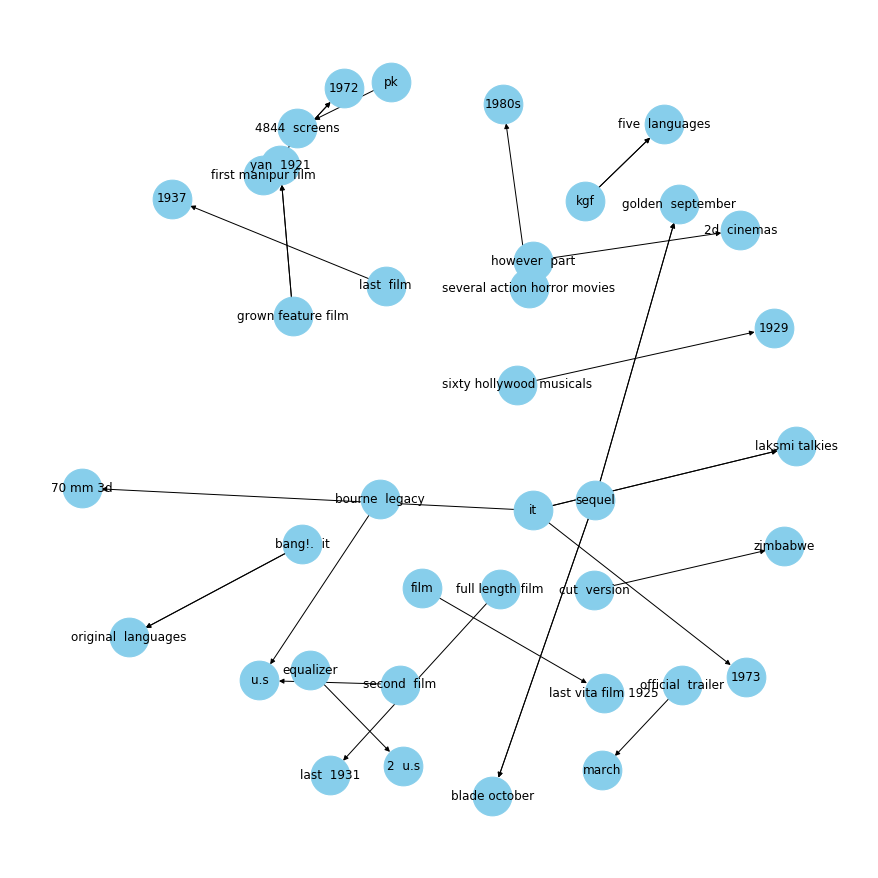

In [39]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()